In [3]:
import tensorflow as tf
import keras
from keras.datasets import mnist
import numpy as np

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
def create_model():
  inputs = keras.layers.Input(shape=(28*28,))
  layer1 = keras.layers.Dense(100, activation='relu')(inputs)
  layer2 = keras.layers.Dense(70, activation='relu')(layer1)
  layer3 = keras.layers.Dense(50, activation='relu')(layer2)
  model = keras.models.Model(inputs=inputs, outputs=[layer1, layer2, layer3])
  return model

In [6]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
 dense_2 (Dense)             (None, 50)                3550      
                                                                 
Total params: 89,120
Trainable params: 89,120
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_of_classes = 10
separated_class_images = []
separated_class_labels = []
for class_number in range(num_of_classes):
  images_of_class = train_images[train_labels == class_number]
  labels_of_class = train_labels[train_labels == class_number]
  separated_class_images.append(images_of_class)
  separated_class_labels.append(labels_of_class)

In [8]:
batches_for_each_class = []
for i in separated_class_labels:
  print(i.shape, 'batches required: ', int(i.shape[0]/256))
  batches_for_each_class.append(int(i.shape[0]/256))
print('\n', batches_for_each_class)

(5923,) batches required:  23
(6742,) batches required:  26
(5958,) batches required:  23
(6131,) batches required:  23
(5842,) batches required:  22
(5421,) batches required:  21
(5918,) batches required:  23
(6265,) batches required:  24
(5851,) batches required:  22
(5949,) batches required:  23

 [23, 26, 23, 23, 22, 21, 23, 24, 22, 23]


In [9]:
count = 0
batch_size = 256
total_rows = sum(batches_for_each_class)*batch_size
dataset = np.zeros((total_rows, 2, 784))
sample_count = 0
for num_of_batches in batches_for_each_class:
  classes = [i for i in range(10)]
  class_wise_count = 0
  classes.remove(count)
  other_data = [separated_class_images[i] for i in classes]
  other_total_data = np.concatenate(other_data, axis = 0)
  for class_count in range(num_of_batches):
    dataset[class_wise_count : class_wise_count + batch_size, 0] = separated_class_images[count][class_wise_count : class_wise_count + batch_size]
    dataset[class_wise_count : class_wise_count + batch_size, 1] = other_total_data[class_wise_count : class_wise_count + batch_size]
    class_wise_count += batch_size
  count += 1
  sample_count += 256

In [10]:
def vicreg_loss(z_a, z_b, var_1_weight = 100, var_2_weight = 25, cov_weight = 1):
  # variance 1 loss
  variance_loss_epsilon = 1e-5
  std_z_a = tf.sqrt(tf.math.reduce_variance(z_a, axis=0) + variance_loss_epsilon)
  #std_z_b = tf.sqrt(tf.math.reduce_variance(z_b, axis=0) + variance_loss_epsilon)
  #loss_v_a = tf.reduce_mean(tf.nn.relu(0.1 - std_z_a))
  loss_v_a = tf.reduce_mean(tf.nn.relu(std_z_a - 0.5))
  #loss_v_b = tf.reduce_mean(tf.nn.relu(10 - std_z_b)) # ekhane careful thakte hobe
  loss_var_1 = loss_v_a # + loss_v_b

  # variance 2 loss
  z_total = tf.stack([z_a, z_b], axis = 0)
  std_z_total = tf.sqrt(tf.math.reduce_variance(z_total, axis = 0) + variance_loss_epsilon)
  std_relu = tf.nn.relu(10 - std_z_total)
  std_mean = tf.reduce_mean(std_relu, axis = 0)
  loss_var_2 = tf.reduce_mean(std_mean, axis = 0)

  #covariance loss
  N, D = z_a.shape
  z_a = z_a - tf.reduce_mean(z_a, axis=0)
  z_b = z_b - tf.reduce_mean(z_b, axis=0)
  cov_z_a = tf.square(tf.matmul(tf.transpose(z_a), z_a) / (N - 1))
  cov_z_b = tf.square(tf.matmul(tf.transpose(z_b), z_b) / (N - 1))
  loss_c_a = (tf.reduce_sum(cov_z_a)- tf.reduce_sum(tf.linalg.diag_part(cov_z_a))) / D
  loss_c_b = (tf.reduce_sum(cov_z_b)- tf.reduce_sum(tf.linalg.diag_part(cov_z_b))) / D
  loss_cov = loss_c_a + loss_c_b

  #total weighted loss
  total_loss = (var_1_weight * loss_var_1) + (var_2_weight * loss_var_2) + (cov_weight * loss_cov)
  return total_loss

In [12]:
layer1 = model.layers[1]
layer2 = model.layers[2]
layer3 = model.layers[3]

layers = [layer1, layer2, layer3]

optimizer_layer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_layer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_layer3 = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizers = [optimizer_layer1, optimizer_layer2, optimizer_layer3]

In [13]:
def plot_figure(data_viz, epoch, repr_img_list, angle):
  fig = plt.figure(figsize=(20, 15))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(data_viz["dim1"], data_viz["dim2"], data_viz["dim3"], c=data_viz["y"], cmap="viridis")

  ax.set_xlabel("Feature 1")
  ax.set_ylabel("Feature 2")
  ax.set_zlabel("Feature 3")

  ax.set_xlim(-20, 20)
  ax.set_ylim(-20, 20)
  ax.set_zlim(-20, 20)

  cbar = fig.colorbar(scatter)
  cbar.set_label("y")

  plt.title(f"Epoch: {epoch}")

  ax.view_init(angle, angle)
  plt.savefig(f"repr_plot_JOJO{epoch}.png")
  repr_img_list.append(f"repr_plot_JOJO{epoch}.png")
  plt.show()

Layer dense - Epoch 0 - Loss: 122.0888
Layer dense_1 - Epoch 0 - Loss: 122.9002
Layer dense_2 - Epoch 0 - Loss: 123.3186
Layer dense - Epoch 0 - Loss: 121.4972
Layer dense_1 - Epoch 0 - Loss: 122.5258
Layer dense_2 - Epoch 0 - Loss: 123.0105
Layer dense - Epoch 0 - Loss: 120.8996
Layer dense_1 - Epoch 0 - Loss: 122.0844
Layer dense_2 - Epoch 0 - Loss: 122.6245
Layer dense - Epoch 0 - Loss: 120.2541
Layer dense_1 - Epoch 0 - Loss: 121.5264
Layer dense_2 - Epoch 0 - Loss: 122.1218
Layer dense - Epoch 0 - Loss: 119.4760
Layer dense_1 - Epoch 0 - Loss: 120.8401
Layer dense_2 - Epoch 0 - Loss: 121.4886
Layer dense - Epoch 0 - Loss: 118.8600
Layer dense_1 - Epoch 0 - Loss: 120.1502
Layer dense_2 - Epoch 0 - Loss: 120.8582
Layer dense - Epoch 0 - Loss: 118.3423
Layer dense_1 - Epoch 0 - Loss: 119.5018
Layer dense_2 - Epoch 0 - Loss: 120.1319
Layer dense - Epoch 0 - Loss: 117.6856
Layer dense_1 - Epoch 0 - Loss: 118.6094
Layer dense_2 - Epoch 0 - Loss: 119.3061
Layer dense - Epoch 0 - Loss: 11

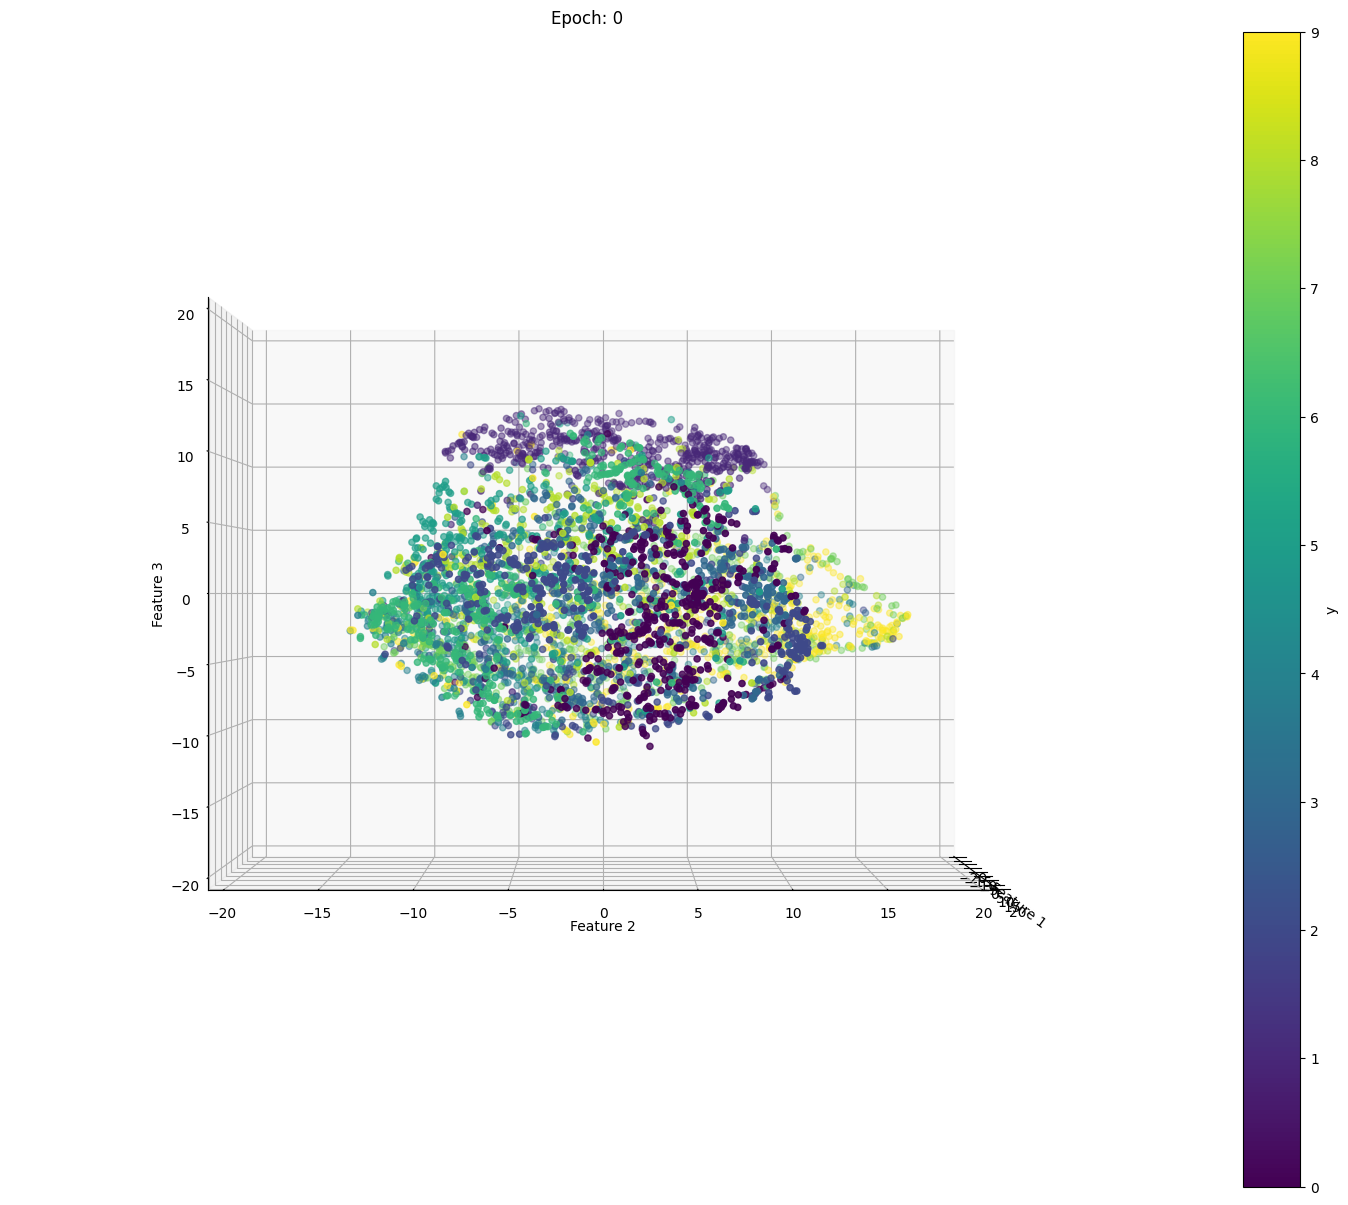

Layer dense - Epoch 1 - Loss: 113.5231
Layer dense_1 - Epoch 1 - Loss: 110.7851
Layer dense_2 - Epoch 1 - Loss: 107.5088
Layer dense - Epoch 1 - Loss: 112.8905
Layer dense_1 - Epoch 1 - Loss: 109.9304
Layer dense_2 - Epoch 1 - Loss: 106.2206
Layer dense - Epoch 1 - Loss: 112.4750
Layer dense_1 - Epoch 1 - Loss: 109.0610
Layer dense_2 - Epoch 1 - Loss: 104.7898
Layer dense - Epoch 1 - Loss: 111.6103
Layer dense_1 - Epoch 1 - Loss: 107.5621
Layer dense_2 - Epoch 1 - Loss: 102.2281
Layer dense - Epoch 1 - Loss: 110.3335
Layer dense_1 - Epoch 1 - Loss: 105.4192
Layer dense_2 - Epoch 1 - Loss: 98.7396
Layer dense - Epoch 1 - Loss: 109.5226
Layer dense_1 - Epoch 1 - Loss: 103.6974
Layer dense_2 - Epoch 1 - Loss: 95.9240
Layer dense - Epoch 1 - Loss: 107.9370
Layer dense_1 - Epoch 1 - Loss: 100.7240
Layer dense_2 - Epoch 1 - Loss: 91.3418
Layer dense - Epoch 1 - Loss: 106.8346
Layer dense_1 - Epoch 1 - Loss: 98.3368
Layer dense_2 - Epoch 1 - Loss: 88.9631
Layer dense - Epoch 1 - Loss: 107.216

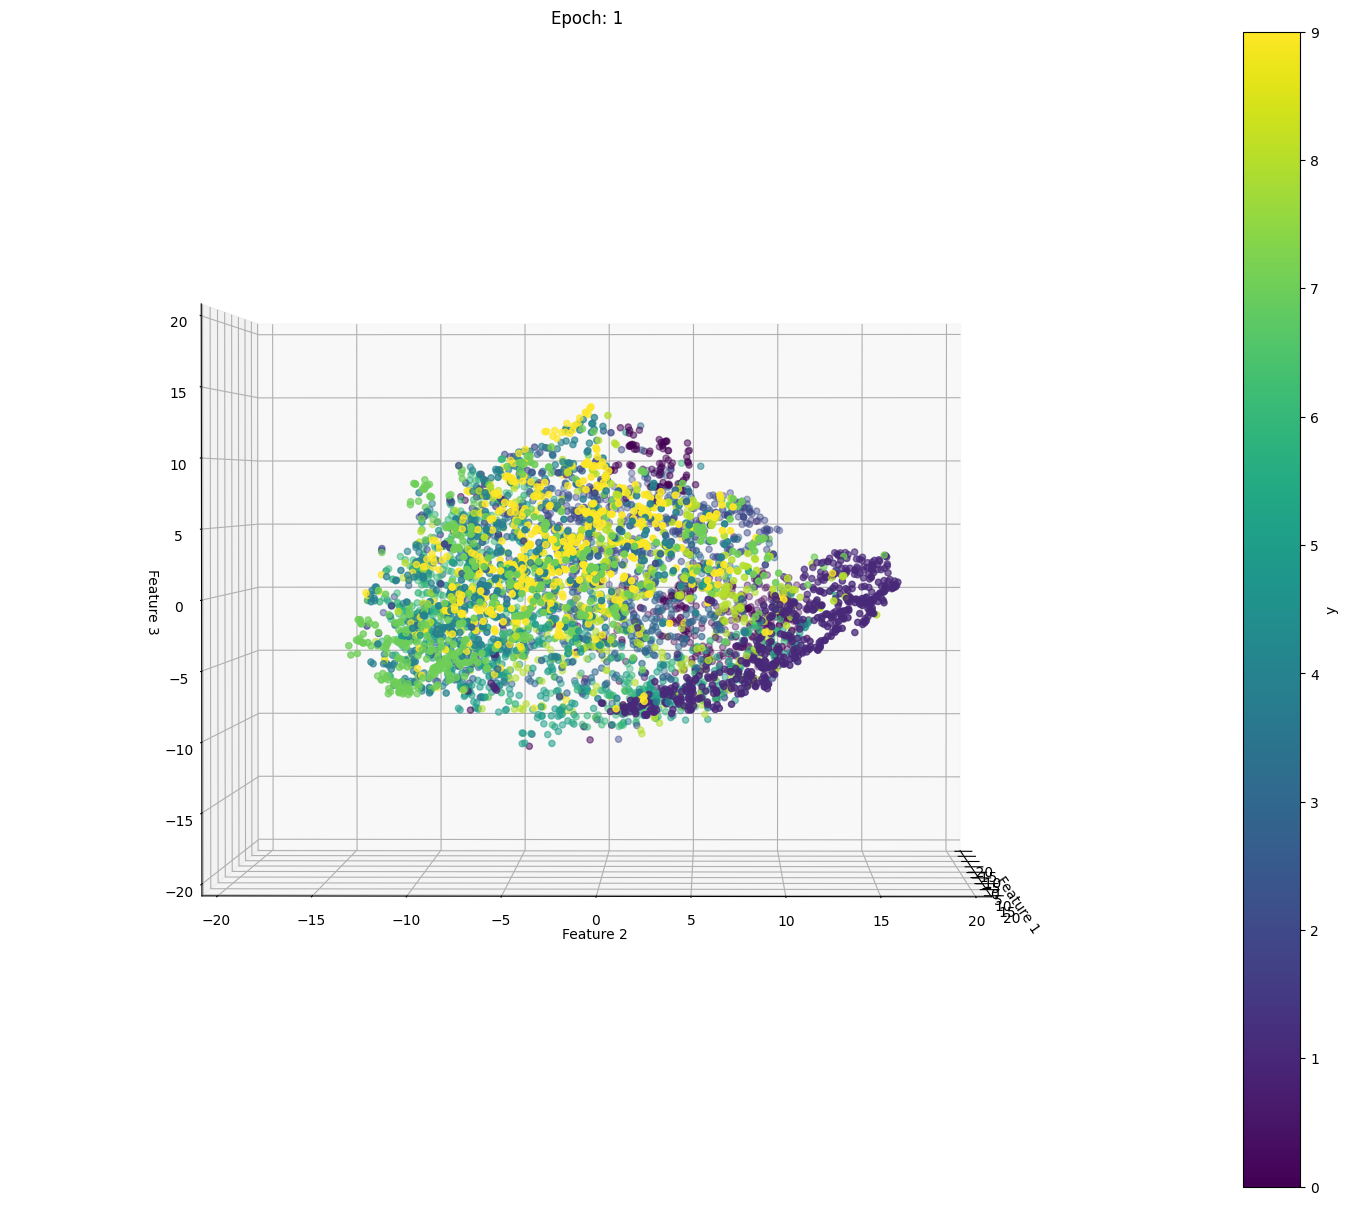

Layer dense - Epoch 2 - Loss: 112.1325
Layer dense_1 - Epoch 2 - Loss: 109.8978
Layer dense_2 - Epoch 2 - Loss: 107.3823
Layer dense - Epoch 2 - Loss: 111.6255
Layer dense_1 - Epoch 2 - Loss: 108.9097
Layer dense_2 - Epoch 2 - Loss: 106.2520
Layer dense - Epoch 2 - Loss: 110.4454
Layer dense_1 - Epoch 2 - Loss: 107.1583
Layer dense_2 - Epoch 2 - Loss: 104.1627
Layer dense - Epoch 2 - Loss: 109.3042
Layer dense_1 - Epoch 2 - Loss: 105.3674
Layer dense_2 - Epoch 2 - Loss: 102.1136
Layer dense - Epoch 2 - Loss: 108.4976
Layer dense_1 - Epoch 2 - Loss: 103.7046
Layer dense_2 - Epoch 2 - Loss: 100.1455
Layer dense - Epoch 2 - Loss: 106.7120
Layer dense_1 - Epoch 2 - Loss: 100.6724
Layer dense_2 - Epoch 2 - Loss: 96.6360
Layer dense - Epoch 2 - Loss: 105.4024
Layer dense_1 - Epoch 2 - Loss: 98.0668
Layer dense_2 - Epoch 2 - Loss: 93.3674
Layer dense - Epoch 2 - Loss: 103.4860
Layer dense_1 - Epoch 2 - Loss: 94.3362
Layer dense_2 - Epoch 2 - Loss: 88.7865
Layer dense - Epoch 2 - Loss: 102.749

In [ ]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
repr_img_list = []
angle = 0
batch_size = 256
epochs = 30
for epoch in range(epochs):
  sample_count = 0
  random.shuffle(dataset)
  for i in range(int(len(dataset) / batch_size)):
    x = dataset[sample_count : sample_count + batch_size, 0, :]
    y = dataset[sample_count : sample_count + batch_size, 1, :]
    for layer, optimizer in zip(layers, optimizers):
      with tf.GradientTape() as tape:
        x = layer(x)
        y = layer(y)
        loss = vicreg_loss(x, y)
      gradients = tape.gradient(loss, layer.trainable_variables)
      optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
      print(f"Layer {layer.name} - Epoch {epoch} - Loss: {loss.numpy():.4f}")
    sample_count += batch_size
  repr = model(test_images[:5000].reshape((-1, 28*28)))[2]
  tsne = TSNE(n_components=3)
  data_3D = tsne.fit_transform(repr)
  data_viz = np.concatenate((data_3D, test_labels[:5000].reshape(len(test_labels[:5000]), 1)), axis = 1)
  data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "dim3", "y"])
  plot_figure(data_viz, epoch, repr_img_list, angle)
  angle += 1

In [ ]:
import imageio
with imageio.get_writer('repr_spacre.gif', mode='I') as writer:
  for filename in repr_img_list:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
tsne = TSNE()
data_2D = tsne.fit_transform(repr = model(test_images[:5000].reshape((-1, 28*28)))[2])

In [ ]:
data_viz = np.concatenate((data_2D, test_labels[:5000].reshape(len(test_labels[:5000]), 1)), axis = 1)
data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
plt.show()

In [11]:
def vicreg_loss(z_a, z_b, var_weight = 25, inv_weight = 25, cov_weight = 1):
  # variance loss
  variance_loss_epsilon = 1e-3
  z_total = tf.stack([z_a, z_b], axis = 0)
  std_z_total = tf.sqrt(tf.math.reduce_variance(z_total, axis = 0) + variance_loss_epsilon)
  std_relu = tf.nn.relu(5 - std_z_total)
  std_mean = tf.reduce_mean(std_relu, axis = 0)
  loss_var = tf.reduce_mean(std_mean, axis = 0)

  #invariance loss
  expanded_matrix = tf.expand_dims(z_a, axis=1)
  squared_differences = tf.square(expanded_matrix - tf.transpose(expanded_matrix, perm=[1, 0, 2]))
  rowwise_mse = tf.reduce_mean(squared_differences, axis=2)
  upper_triangular_mask = tf.linalg.band_part(tf.ones_like(rowwise_mse), 0, -1)
  output_tensor = rowwise_mse * upper_triangular_mask
  nonzero_elems = tf.math.count_nonzero(output_tensor)
  row_sums = tf.reduce_sum(output_tensor, axis=1, keepdims=True)
  total_sum = tf.reduce_sum(row_sums)
  loss_inv = total_sum/nonzero_elems.numpy()
  if loss_inv <= 100:
    loss_inv = tf.constant(0.)

  #covariance loss
  N, D = z_a.shape
  z_a = z_a - tf.reduce_mean(z_a, axis=0)
  z_b = z_b - tf.reduce_mean(z_b, axis=0)
  cov_z_a = tf.square(tf.matmul(tf.transpose(z_a), z_a) / (N - 1))
  cov_z_b = tf.square(tf.matmul(tf.transpose(z_b), z_b) / (N - 1))
  loss_c_a = (tf.reduce_sum(cov_z_a)- tf.reduce_sum(tf.linalg.diag_part(cov_z_a))) / D
  loss_c_b = (tf.reduce_sum(cov_z_b)- tf.reduce_sum(tf.linalg.diag_part(cov_z_b))) / D
  loss_cov = loss_c_a + loss_c_b

  #total weighted loss
  total_loss = (var_weight * loss_var) + (inv_weight * loss_inv) + (cov_weight * loss_cov)
  return total_loss